## Notebook for Drop

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import itertools

### Load all the data

In [2]:

def hdf5_to_dict(filename):
    """Convert HDF5 file to dictionary"""
    def load_item(name, obj):
        if isinstance(obj, h5py.Dataset):
            data_dict[name] = obj[()]  # Load dataset
        elif isinstance(obj, h5py.Group):
            data_dict[name] = {}  # Create group dict
    
    with h5py.File(filename, 'r') as f:
        data_dict = {key: f[key][()] if isinstance(f[key], h5py.Dataset) else {} 
                     for key in f.keys()}
        f.visititems(load_item)
    
    return data_dict

# INSERT PATH OF THE FILE HERE

filename = './combined_subruns.h5'  # Example


# Load the file
data = hdf5_to_dict(filename)



In [3]:
# Temperature channel mappings
pcm_brd_ids = {
    0: "T gen (slave)",
    1: "T SiPM (slave)",
    2: "T LED (slave)",
    4: "T gen. (master)",
    5: "T SiPM (master)",
    6: "T LED (master)",
    7: "T IB"
}

# Voltage channel mappings
voltage_channel_names = {
    0: 'sipm2',
    1: 'sipm1',
    2: 'mmb33',
    3: 'mmb18',
    4: 'kapu2',
    5: 'lmg2',
    6: 'lmg1',
    7: 'kapu1'
}



### Caltrig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


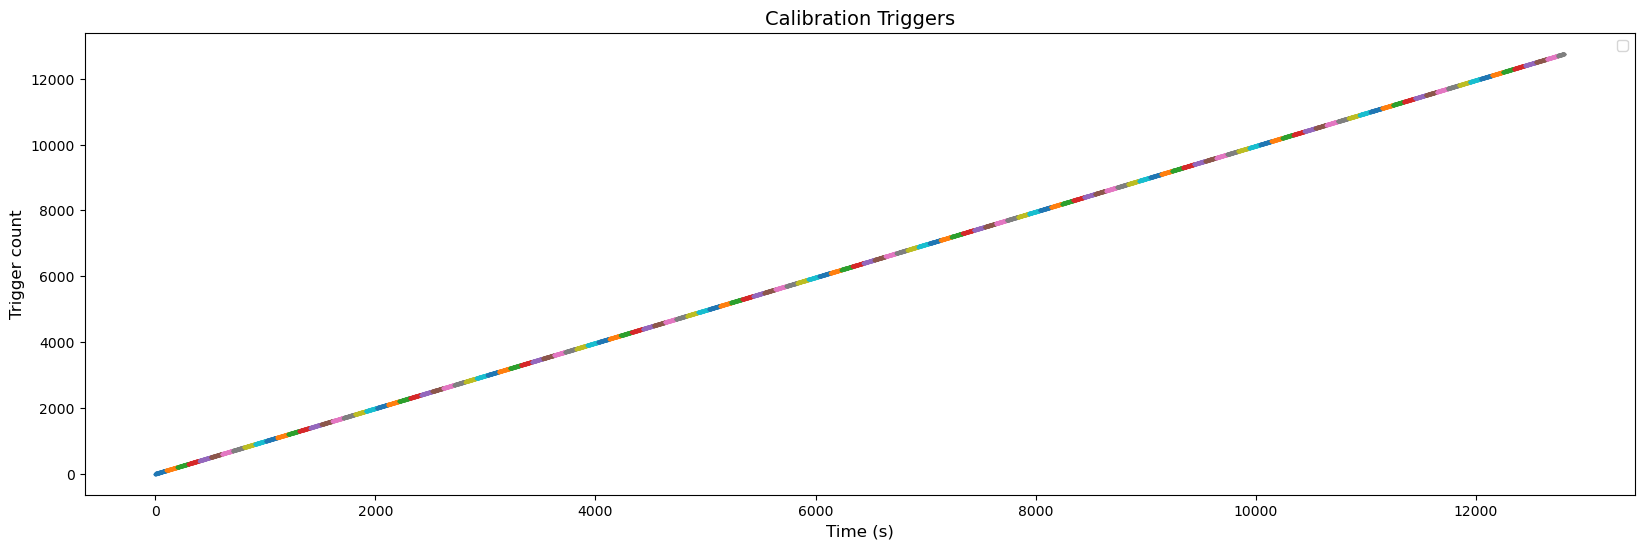

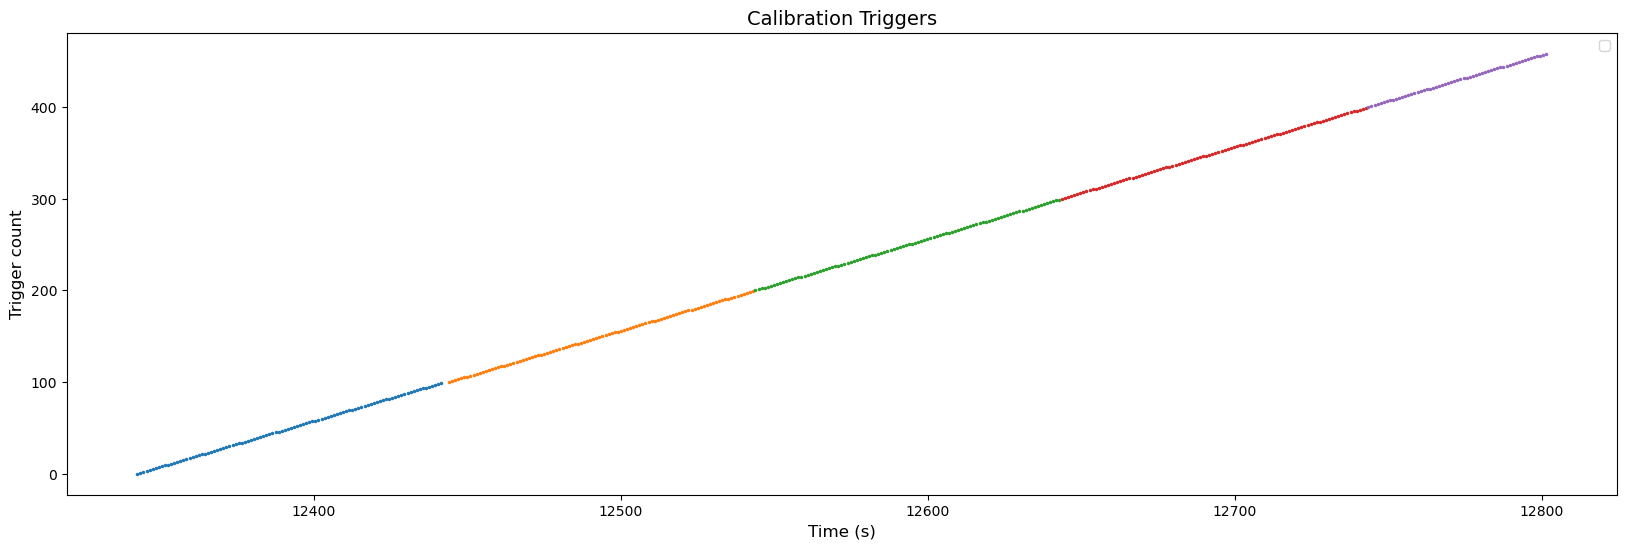

In [112]:

def plot_caltrig_with_subruns(hdf5_file, idx, figsize=(20, 6)):
    """Plot calibration triggers aligned with subruns."""
    
    # Load caltrig data directly from HDF5
    caltrig_data = []
    with h5py.File(hdf5_file, 'r') as f:
        for subrun_key in sorted(f.keys()):
            if subrun_key.startswith('subrun_'):
                try:
                    caltrig = f[f'{subrun_key}/cal_trig_000'][()]
                    caltrig_data.append(caltrig)
                except KeyError:
                    continue
    

    fig, ax = plt.subplots(figsize=figsize)
    
    scale = 1 / (8*60e6)
    first_trig = caltrig_data[0][0]


    c = 0
    for i, lst in enumerate(caltrig_data[idx:]):
        subtrigs = (lst - first_trig) * scale
            #subtrigs = lst * scale
            #deltas = np.diff(subtrigs)
        #plt.plot(subtrigs, np.full(len(subtrigs), i), '.', markersize=3)

        x = list(np.array((range(len(lst))))+c)
        plt.plot(subtrigs, x, '.', markersize=3)
        c += len(lst)
    
    
    #subrun_times_s = []
    #cumulative = 0
    #for cal_trigs in caltrig_data:
    #    subrun_times_s.append(all_caltrigs_s[cumulative])
    #    cumulative += len(cal_trigs)


    ax.set_ylabel("Trigger count", fontsize=12)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_title("Calibration Triggers", fontsize=14)
    ax.legend(fontsize=10)
    #ax.set_xlim(0, all_caltrigs_s[-1] + 10)

    return fig, ax

fig, ax = plot_caltrig_with_subruns(filename, idx = 0)
fig, ax = plot_caltrig_with_subruns(filename, idx = -5) # idx takes the subruns you want


### Temperature

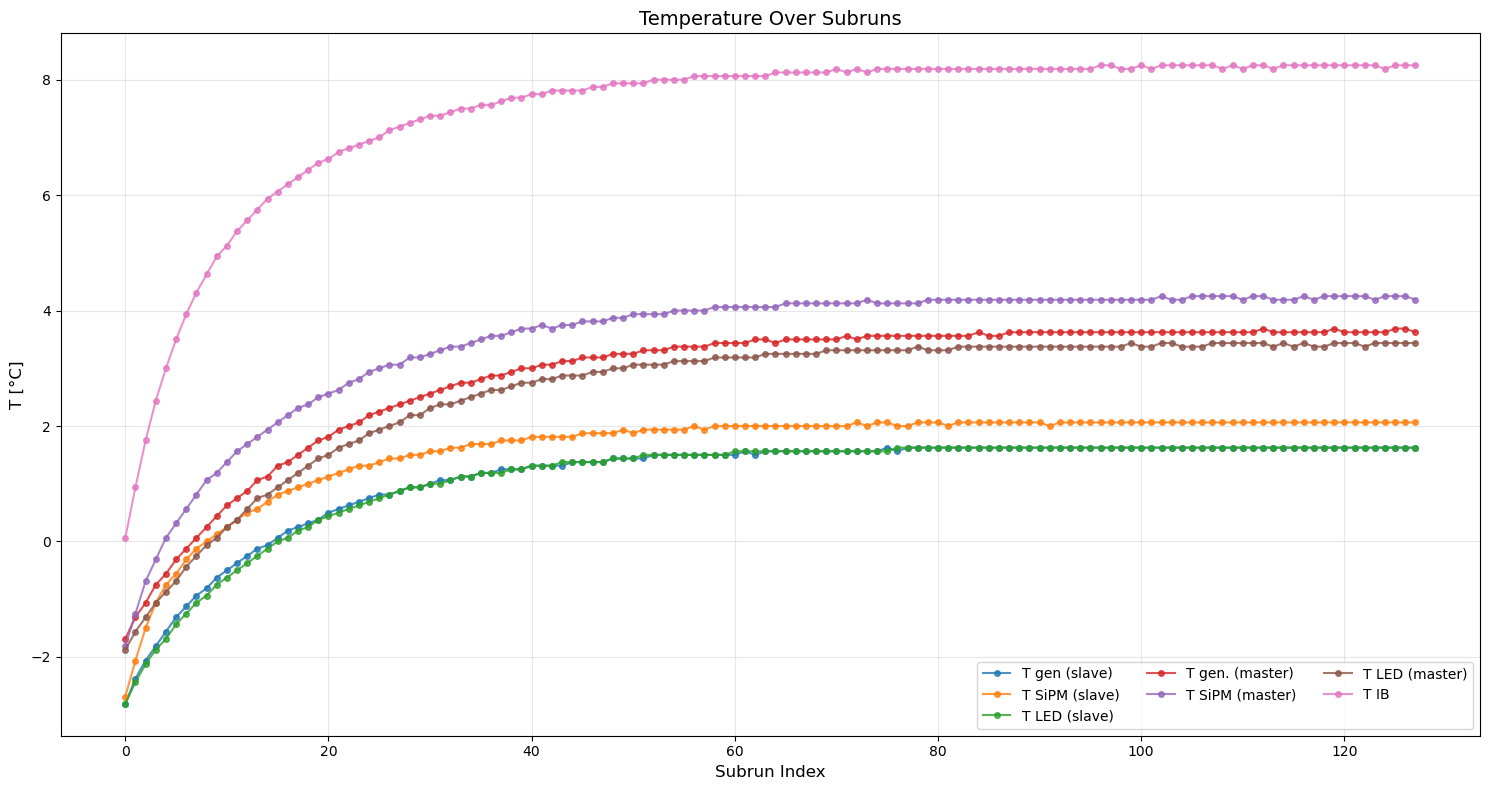

In [5]:


def plot_temperatures(hdf5_file, figsize=(15, 8)):
    """Plot temperature data from all subruns"""
    
    # Load temperature data directly from HDF5
    temp_data = []
    with h5py.File(hdf5_file, 'r') as f:
        for subrun_key in sorted(f.keys()):
            if subrun_key.startswith('subrun_'):
                try:
                    temp_records = f[f'{subrun_key}/temperature_000'][()]
                    temp_data.append(temp_records)
                except KeyError:
                    continue
    
    fig, ax = plt.subplots(figsize=figsize)
    
    channel_colors = {}
    channel_data = {}
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    
    for subrun_idx, temp_records in enumerate(temp_data):
        t0 = subrun_idx
        
        for record in temp_records:
            ch = int(record['channel'])
            temp = float(record['celcius'])
            
            if ch not in channel_colors:
                channel_colors[ch] = next(colors)
                channel_data[ch] = {'x': [], 'y': []}
            
            channel_data[ch]['x'].append(t0)
            channel_data[ch]['y'].append(temp)
    
    for ch in sorted(channel_data.keys()):
        label = pcm_brd_ids.get(ch, f"ch{ch}") 
        x = channel_data[ch]['x']
        y = channel_data[ch]['y']
        ax.plot(x, y, 'o-', color=channel_colors[ch], markersize=4, linewidth=1.5,
               label=label, alpha=0.8)
    
    ax.set_ylabel("T [°C]", fontsize=12)
    ax.set_xlabel("Subrun Index", fontsize=12)
    ax.set_title("Temperature Over Subruns", fontsize=14)
    ax.legend(ncol=3, fontsize=10)
    ax.grid(True, alpha=0.3)
    
    return fig, ax


fig, ax = plot_temperatures(filename)
plt.tight_layout()
plt.show()

### Voltage

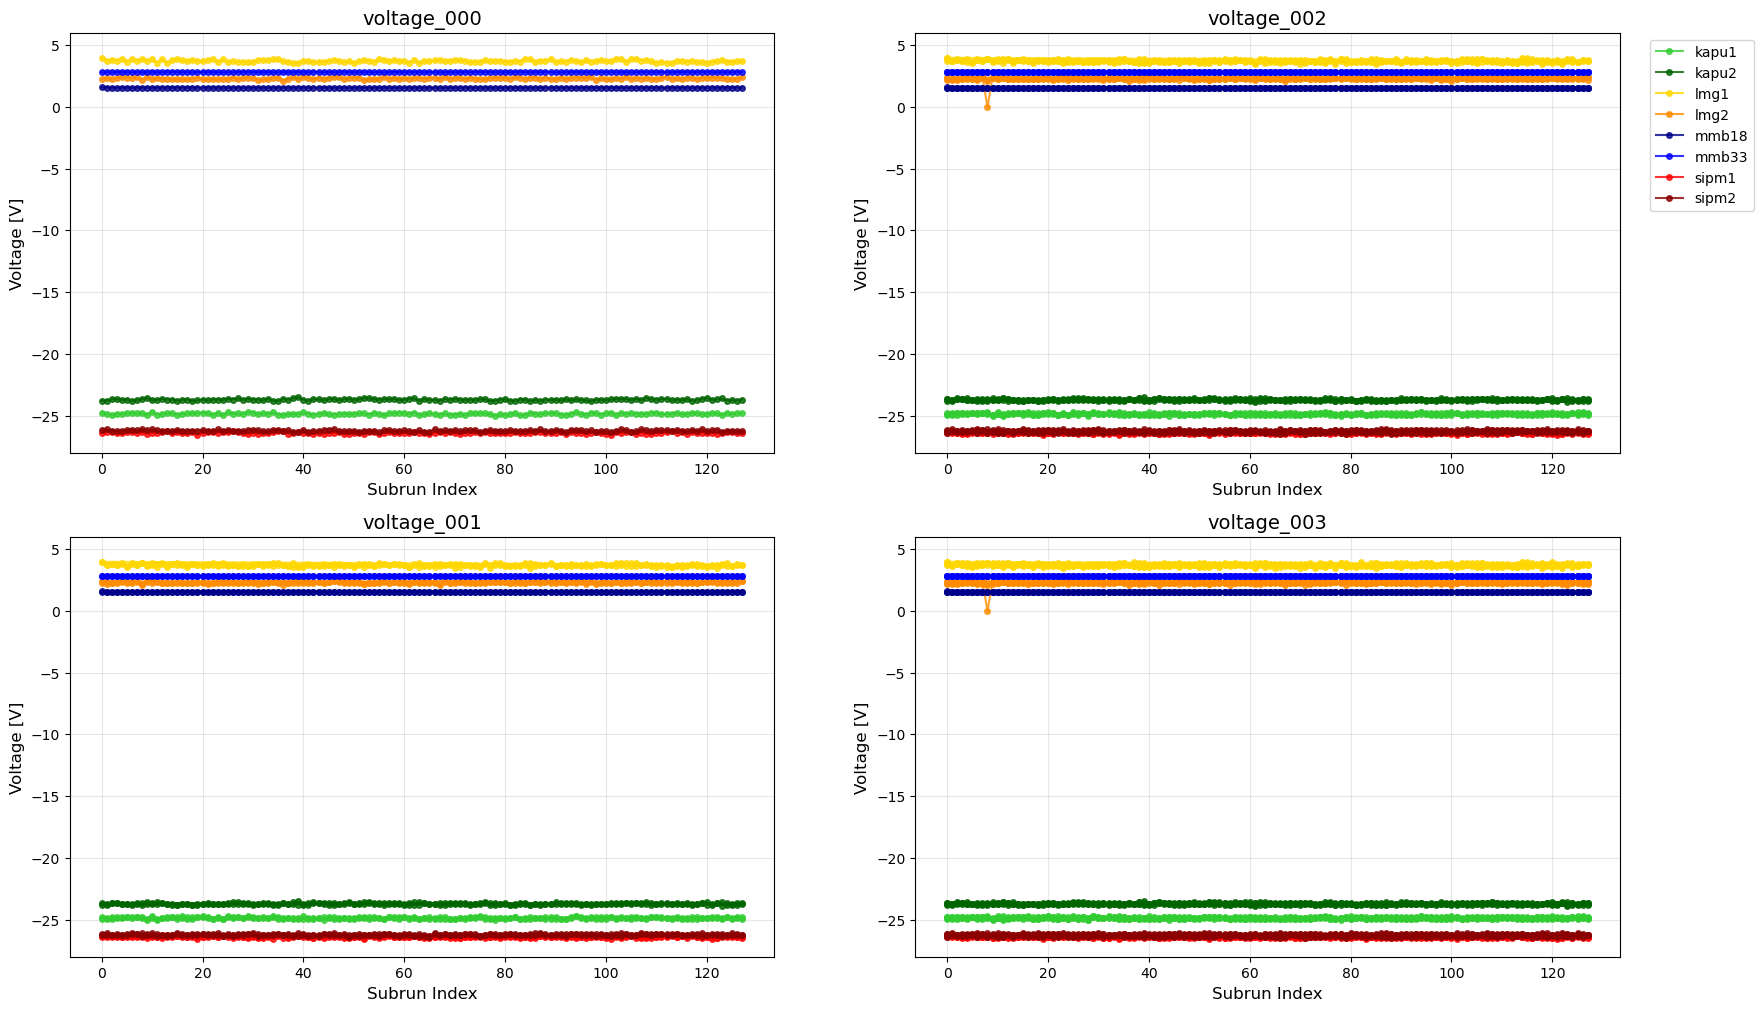

In [64]:

def plot_voltages(hdf5_file):
    """Plot voltage data from all subruns"""
    
    # Load voltage data directly from HDF5
    voltage_data = {}
    with h5py.File(hdf5_file, 'r') as f:
        for subrun_key in sorted(f.keys()):
            if subrun_key.startswith('subrun_'):
                try:
                    # Load all voltage datasets (voltage_000, voltage_001, etc.)
                    for volt_key in f[subrun_key].keys():
                        if volt_key.startswith('voltage_'):
                            volt_records = f[f'{subrun_key}/{volt_key}'][()]
                            if not volt_key in voltage_data.keys():
                                voltage_data[volt_key] = []                               

                            voltage_data[volt_key].append(volt_records)

                except KeyError:
                    continue
    

    fig, axes = plt.subplots(2, 2, figsize = (20, 12))    

    channel_colors = {
        'sipm1': 'red',
        'sipm2': 'darkred',
        'mmb33': 'blue',
        'mmb18': 'darkblue',
        'kapu1': 'limegreen',
        'kapu2': 'darkgreen',
        'lmg1': 'gold',
        'lmg2': 'darkorange'
    }
    
    channel_data = {ch: {'x': [], 'y': []} for ch in channel_colors.keys()}

    for i, vlt_run in enumerate(voltage_data.keys()):

        if i in [0,1]:
            col = 0
            ln = i
        else:
            col = 1
            ln = i-2
        


        vlt_run_data = voltage_data[vlt_run]
        for t0, volt_records in enumerate(vlt_run_data):
            for record in volt_records:
                ch = int(record['channel'])
                voltage = float(record['voltage'])
                
                channel_name = voltage_channel_names.get(ch, f'ch{ch}')
                if channel_name in channel_data:
                    channel_data[channel_name]['x'].append(t0)
                    channel_data[channel_name]['y'].append(voltage)
               
        for channel in sorted(channel_data.keys()):
            if len(channel_data[channel]['x']) > 0:
                x = channel_data[channel]['x']
                y = channel_data[channel]['y']
                axes[ln,col].plot(x, y, 'o-', color=channel_colors[channel], markersize=4,
                    linewidth=1.5, alpha=0.8, label=channel)
    
        axes[ln,col].set_ylim(-28, 6)
        axes[ln,col].set_ylabel("Voltage [V]", fontsize=12)
        axes[ln,col].set_xlabel("Subrun Index", fontsize=12)
        axes[ln,col].set_title(vlt_run, fontsize=14)
        axes[ln,col].grid(True, alpha=0.3)
    
    axes[0,1].legend(loc='upper right', fontsize=10, bbox_to_anchor=(1.2, 1))

    return fig, axes

fig, axes = plot_voltages(filename)
#plt.tight_layout()
#plt.show()

### Pressure

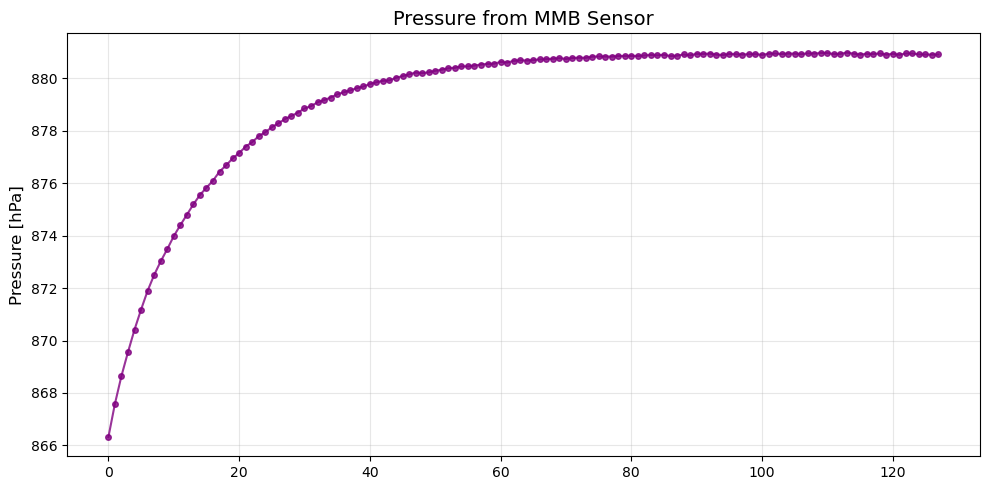

In [8]:


def plot_pressure(hdf5_file, figsize=(10, 5)):
    """Plot pressure data from all subruns"""
    
    # Load MMB sensor data directly from HDF5
    mmb_data = []
    with h5py.File(hdf5_file, 'r') as f:
        subruns = sorted([k for k in f.keys() if k.startswith('subrun_')])
        for subrun_name in subruns:
            subrun_group = f[subrun_name]
            if 'mmb_sensor_000' in subrun_group:
                data = subrun_group['mmb_sensor_000'][0]
                mmb_data.append({
                    'accel_x': data['accelerometerXYZ'][0],
                    'accel_y': data['accelerometerXYZ'][1],
                    'accel_z': data['accelerometerXYZ'][2],
                    'accel_temp': data['accelerometerT'],
                    'magf_x': data['magnetometerXYZ'][0],
                    'magf_y': data['magnetometerXYZ'][1],
                    'magf_z': data['magnetometerXYZ'][2],
                    'magf_temp': data['magnetometerT'],
                    'pressure': data['pressureP'],
                    'pressure_temp': data['pressureT']
                })
    
    fig, axes = plt.subplots(1, 1, figsize=figsize, sharex=True)
    
    pressure = [d['pressure'] for d in mmb_data]
    pressure_temp = [d['pressure_temp'] for d in mmb_data]
    x_indices = np.arange(len(mmb_data))
    
    axes.plot(x_indices, pressure, 'o-', color='purple', markersize=4,
                linewidth=1.5, alpha=0.8)
    axes.set_ylabel("Pressure [hPa]", fontsize=12)
    axes.set_title("Pressure from MMB Sensor", fontsize=14)
    axes.grid(True, alpha=0.3)
    
    #axes[1].plot(x_indices, pressure_temp, 'o-', color='brown', markersize=4,
    #            linewidth=1.5, alpha=0.8)
    #axes[1].set_ylabel("Temperature [°C]", fontsize=12)
    #axes[1].set_xlabel("Subrun Index", fontsize=12)
    #axes[1].set_title("Pressure Sensor Temperature", fontsize=14)
    #axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, axes

fig, axes = plot_pressure(filename)
plt.show()

### Accelerometer

<span style="color:red">
Missing relative angle plot
</span>

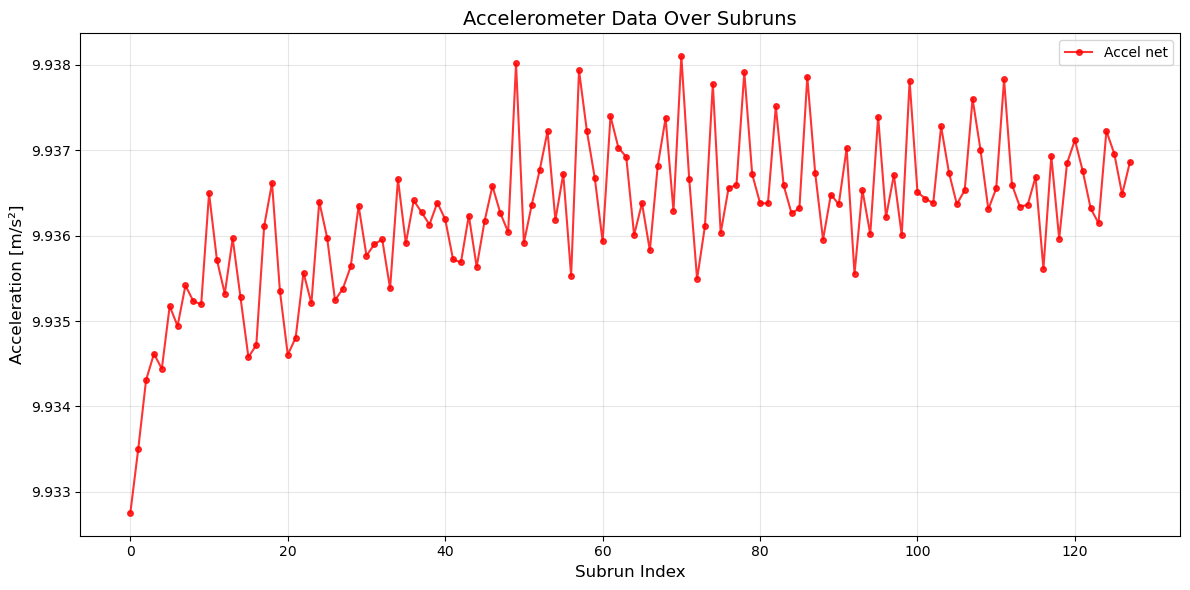

In [9]:

def plot_accelerometer(hdf5_file, figsize=(12, 6)):
    """Plot accelerometer data from all subruns."""
    
    # Load MMB sensor data directly from HDF5
    mmb_data = []
    with h5py.File(hdf5_file, 'r') as f:
        subruns = sorted([k for k in f.keys() if k.startswith('subrun_')])
        for subrun_name in subruns:
            subrun_group = f[subrun_name]
            if 'mmb_sensor_000' in subrun_group:
                data = subrun_group['mmb_sensor_000'][0]
                mmb_data.append({
                    'accel_x': data['accelerometerXYZ'][0],
                    'accel_y': data['accelerometerXYZ'][1],
                    'accel_z': data['accelerometerXYZ'][2],
                    'accel_temp': data['accelerometerT'],
                    'magf_x': data['magnetometerXYZ'][0],
                    'magf_y': data['magnetometerXYZ'][1],
                    'magf_z': data['magnetometerXYZ'][2],
                    'magf_temp': data['magnetometerT'],
                    'pressure': data['pressureP'],
                    'pressure_temp': data['pressureT']
                })
    
    fig, ax = plt.subplots(figsize=figsize)
    
    accel_x = np.array([d['accel_x'] for d in mmb_data])
    accel_y = np.array([d['accel_y'] for d in mmb_data])
    accel_z = np.array([d['accel_z'] for d in mmb_data])

    g = np.sqrt(accel_x**2+accel_y**2+accel_z**2)
    
    x_indices = np.arange(len(mmb_data))

    ax.plot(x_indices, g, 'o-', color='red', markersize=4,
           linewidth=1.5, alpha=0.8, label='Accel net')

    '''
    ax.plot(x_indices, accel_x, 'o-', color='red', markersize=4,
           linewidth=1.5, alpha=0.8, label='Accel X')
    ax.plot(x_indices, accel_y, 's-', color='green', markersize=4,
           linewidth=1.5, alpha=0.8, label='Accel Y')
    ax.plot(x_indices, accel_z, '^-', color='blue', markersize=4,
           linewidth=1.5, alpha=0.8, label='Accel Z')
    '''
    
    ax.set_ylabel("Acceleration [m/s²]", fontsize=12)
    ax.set_xlabel("Subrun Index", fontsize=12)
    ax.set_title("Accelerometer Data Over Subruns", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    
    return fig, ax

fig, ax = plot_accelerometer(filename)
plt.tight_layout()
plt.show()

ADC

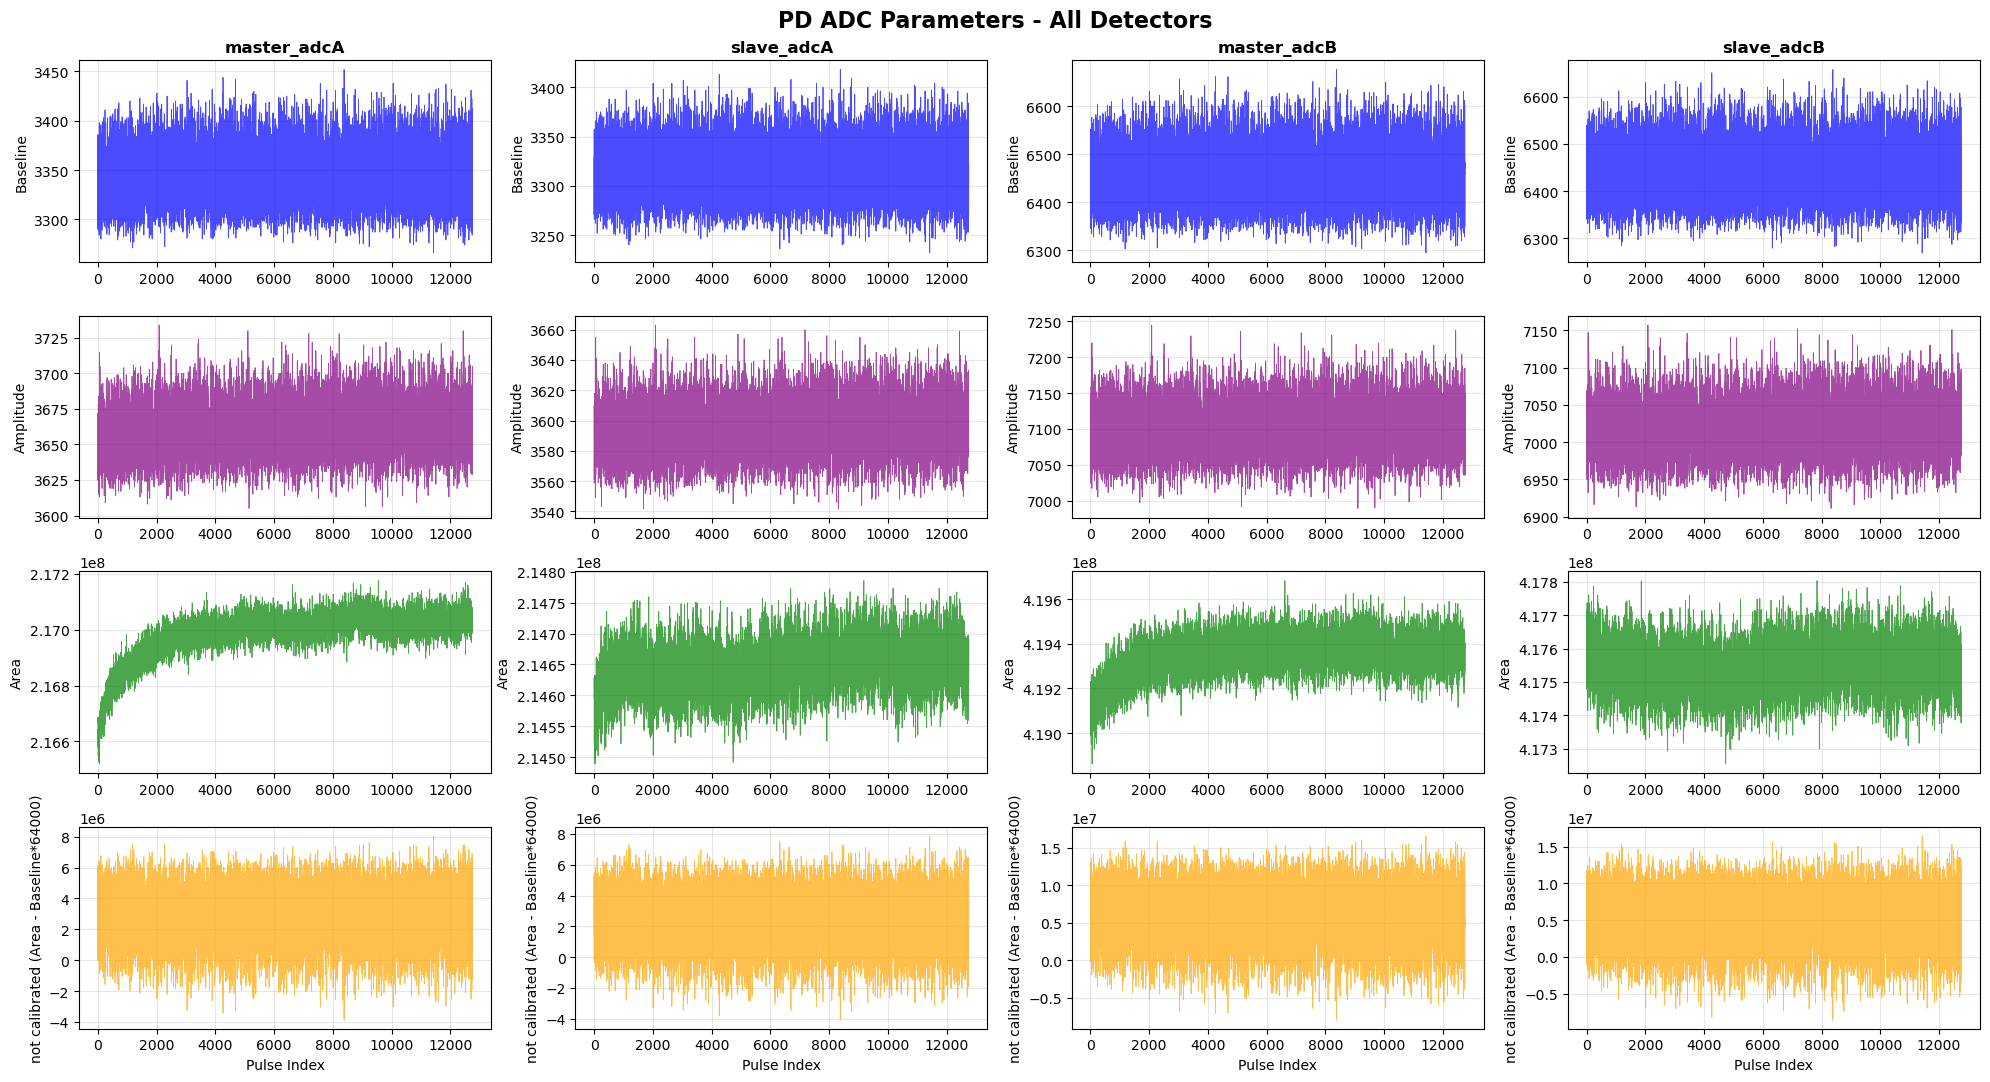

In [68]:


def plot_adc_parameters(hdf5_file):
    """Plot ADC parameters organized by target and channel.
    
    Args:
        hdf5_file: Path to HDF5 file
        target_channel: Tuple (target, channel) to plot specific detector.
                       E.g., (1, 0xA), (1, 0xB), (2, 0xA), (2, 0xB)
                       If None, plots all 4 detectors in columns.
        
    """
    
    # Load ADC data directly from HDF5
    adc_data = {}
    
    with h5py.File(hdf5_file, 'r') as f:
        subruns = sorted([k for k in f.keys() if k.startswith('subrun_')])
        
        for subrun_name in subruns:
            subrun_group = f[subrun_name]
            
            for group_idx in range(4):
                adc_key = f'adc_{group_idx:03d}'
                if adc_key not in subrun_group:
                    continue
                
                adc_group = subrun_group[adc_key]
                
                # Read header to get source information
                header = adc_group['header'][0]
                source = header['source']
                
                # Decode source: 0xTC where T=target, C=channel
                target = (source >> 4) & 0xF
                channel = source & 0xF
                key = (target, channel)
                
                # Initialize key if not seen before
                if key not in adc_data:
                    adc_data[key] = {'baseline': [], 'max_ampl': [], 'area': [], 
                                     'header': []}
                
                # Read records
                records = adc_group['records'][:]
                
                # Apply correction: if baseline or max_ampl > 10000, subtract 2^15
                baseline = np.array(records['base'], dtype=np.float64)
                max_ampl = np.array(records['max_ampl'], dtype=np.float64)
                
                baseline[baseline > 10000] -= 2**15
                max_ampl[max_ampl > 10000] -= 2**15

                #baseline *= 64000
                
                adc_data[key]['baseline'].extend(baseline)
                adc_data[key]['max_ampl'].extend(max_ampl)
                adc_data[key]['area'].extend(records['area'])
                
                # Store header info
                adc_data[key]['header'].append({
                    'source': source,
                    'target': target,
                    'channel': channel,
                    'n_records': header['n_records'],
                    'averaging': header['averaging'],
                    'window': header['window']
                })
    
    # Convert lists to arrays
    for key in adc_data:
        adc_data[key]['baseline'] = np.array(adc_data[key]['baseline'])
        adc_data[key]['max_ampl'] = np.array(adc_data[key]['max_ampl'])
        adc_data[key]['area'] = np.array(adc_data[key]['area'])
    
   
    all_keys = sorted(adc_data.keys())
    all_keys[1],all_keys[2] = all_keys[2],all_keys[1]


    # Plot all detectors (typically 4: T1ChA, T1ChB, T2ChA, T2ChB)
    n_detectors = len(all_keys)
    fig, axes = plt.subplots(4, n_detectors, figsize=(5*n_detectors, 11), sharex=False)
    #fig_c, axes_c = plt.subplots(1, n_detectors, figsize=(5*n_detectors, 3))
    
    if n_detectors == 1:
        axes = axes.reshape(-1, 1)
    
    for col_idx, key in enumerate(all_keys):
        tg, channel = key
        if tg ==1:
            target = 'master'
        elif tg ==2:
            target = 'slave'

        baseline = adc_data[key]['baseline']
        max_ampl = adc_data[key]['max_ampl']
        area = adc_data[key]['area']
        amplitude = max_ampl - baseline
        charge = area - baseline*64000
        
        pulse_indices = np.arange(len(baseline))
        
        # Row 1: Baseline & Max
        axes[0, col_idx].plot(pulse_indices, baseline, color='blue', linewidth=0.6, alpha=0.7)
        #axes[0, col_idx].plot(pulse_indices, max_ampl, color='red', linewidth=0.6, alpha=0.7, label='Max')
        axes[0, col_idx].set_title(f"{target}_adc{channel:X}", fontsize=12, fontweight='bold')
        axes[0, col_idx].grid(True, alpha=0.3)
        axes[0, col_idx].set_ylabel("Baseline", fontsize=10)
        
        
        # Row 2: Amplitude
        axes[1, col_idx].plot(pulse_indices, max_ampl, color='purple', linewidth=0.6, alpha=0.7)
        axes[1, col_idx].grid(True, alpha=0.3)
        axes[1, col_idx].set_ylabel("Amplitude", fontsize=10)

        # Row 3: Area
        axes[2, col_idx].plot(pulse_indices, area, color='green', linewidth=0.6, alpha=0.7)
        axes[2, col_idx].grid(True, alpha=0.3)
        axes[2, col_idx].set_ylabel("Area", fontsize=10)

        
        # extra Row 4: Charge
        axes[3, col_idx].plot(pulse_indices, charge, color='orange', linewidth=0.6, alpha=0.7)
        axes[3, col_idx].grid(True, alpha=0.3)
        axes[3, col_idx].set_ylabel("not calibrated (Area - Baseline*64000)", fontsize=10)
        axes[3, col_idx].set_xlabel("Pulse Index", fontsize=10)
        
        fig.suptitle('PD ADC Parameters - All Detectors', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig, axes#, fig_c, axes_c




fig, axes = plot_adc_parameters(filename)
plt.show()

In [109]:
import json
with open('drop_op_adc_nph_conversion.json', 'r') as f:
        conv_data = json.load(f)
mmb_id = '3200000067249a42'    # MMB_ID still not ready to be read out via file     device 013 for string 90  -->  mmb_id = 3200000067249a42
conv = conv_data[mmb_id]

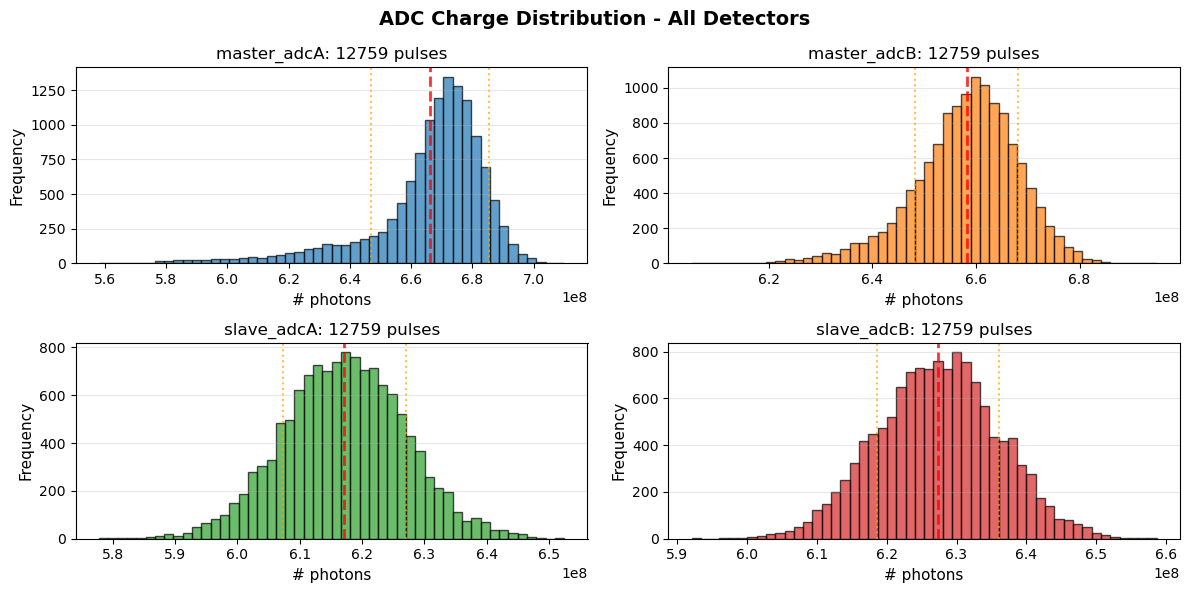

In [108]:
def plot_adc_ph_histogram(hdf5_file, target_channel=None, bins=50, figsize=(12, 6)):
    """Plot histogram of charge (area - baseline).
    
    Args:
        hdf5_file: Path to HDF5 file
        target_channel: Tuple (target, channel) for specific detector. If None, plot all.
        bins: Number of histogram bins
   
    """
    
    # Load ADC data directly from HDF5
    adc_data = {}
    
    with h5py.File(hdf5_file, 'r') as f:
        subruns = sorted([k for k in f.keys() if k.startswith('subrun_')])
        
        for subrun_name in subruns:
            subrun_group = f[subrun_name]
            
            for group_idx in range(4):
                adc_key = f'adc_{group_idx:03d}'
                if adc_key not in subrun_group:
                    continue
                
                adc_group = subrun_group[adc_key]
                
                # Read header to get source information
                header = adc_group['header'][0]
                source = header['source']
                
                # Decode source: 0xTC where T=target, C=channel
                target = (source >> 4) & 0xF
                channel = source & 0xF
                key = (target, channel)
                
                # Initialize key if not seen before
                if key not in adc_data:
                    adc_data[key] = {'baseline': [], 'max_ampl': [], 'area': []}
                
                # Read records
                records = adc_group['records'][:]
                
                # Apply correction: if baseline or max_ampl > 10000, subtract 2^15
                baseline = np.array(records['base'], dtype=np.float64)
                max_ampl = np.array(records['max_ampl'], dtype=np.float64)
                
                baseline[baseline > 10000] -= 2**15
                max_ampl[max_ampl > 10000] -= 2**15

                baseline *= 64000
                
                adc_data[key]['baseline'].extend(baseline)
                adc_data[key]['max_ampl'].extend(max_ampl)
                adc_data[key]['area'].extend(records['area'])
    
    # Convert lists to arrays
    for key in adc_data:
        adc_data[key]['baseline'] = np.array(adc_data[key]['baseline'])
        adc_data[key]['max_ampl'] = np.array(adc_data[key]['max_ampl'])
        adc_data[key]['area'] = np.array(adc_data[key]['area'])
    
    all_keys = sorted(adc_data.keys())


    # Plot all detectors
    n_detectors = len(all_keys)
    fig, axes = plt.subplots(2, 2, figsize=figsize if n_detectors == 4 else (10, 8))
    axes = axes.flatten()
    
    for idx, key in enumerate(all_keys):
        tg, channel = key
        chan = f'{channel:X}'
        if tg ==1:
            target = 'master'
        elif tg ==2:
            target = 'slave'

        baseline = adc_data[key]['baseline']
        area = adc_data[key]['area']
        m_ = conv[target]['fit_para_adc'+chan]
        mean_base = np.mean(baseline)

        all_charge = (area-mean_base)*m_[0]+m_[1]
        
        valid_mask = np.isfinite(all_charge)
        all_charge_clean = all_charge[valid_mask]
        
        counts, edges, patches = axes[idx].hist(all_charge_clean, bins=bins, 
                                                color=f'C{idx}', edgecolor='black', alpha=0.7)
        
        axes[idx].set_xlabel("# photons", fontsize=11)
        axes[idx].set_ylabel("Frequency", fontsize=11)
        axes[idx].set_title(f"{target}_adc{channel:X}: {len(all_charge_clean)} pulses", fontsize=12)
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        mean_charge = np.mean(all_charge_clean)
        std_charge = np.std(all_charge_clean)
        axes[idx].axvline(mean_charge, color='red', linestyle='--', linewidth=2, alpha=0.8)
        axes[idx].axvline(mean_charge - std_charge, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
        axes[idx].axvline(mean_charge + std_charge, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    
    for idx in range(len(all_keys), 4):
        axes[idx].set_visible(False)
    
    fig.suptitle('ADC Charge Distribution - All Detectors', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig, axes


fig, ax = plot_adc_ph_histogram(filename)


Difference last caltrig and next subrun 

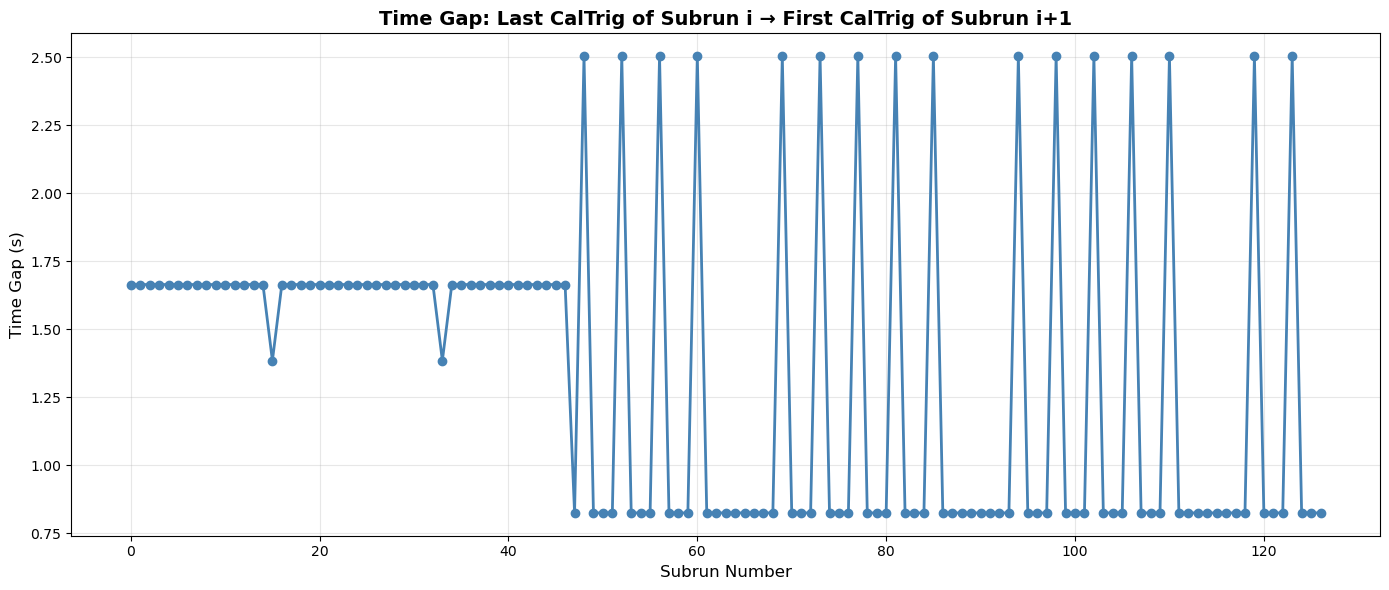

In [43]:


def plot_caltrig_time_gaps(hdf5_file):
    """
    Plot the time difference between the last caltrig event in subrun i
    and the first caltrig event in subrun i+1.
    """
    
    time_gaps = []
    subrun_numbers = []
    
    with h5py.File(hdf5_file, 'r') as f:
        # Get all subrun keys in order
        subruns = sorted([k for k in f.keys() if k.startswith('subrun_')], 
                        key=lambda x: int(x.split('_')[1]))
        
        for i in range(len(subruns) - 1):
            current_subrun = subruns[i]
            next_subrun = subruns[i + 1]
            
            # Get cal_trig data from current subrun
            cal_trig_key = f'{current_subrun}/cal_trig_000'
            if cal_trig_key not in f:
                continue
            
            cal_trig_current = f[cal_trig_key][:]
            
            # Get cal_trig data from next subrun
            next_cal_trig_key = f'{next_subrun}/cal_trig_000'
            if next_cal_trig_key not in f:
                continue
            
            cal_trig_next = f[next_cal_trig_key][:]
            
            # Check if both have data
            if len(cal_trig_current) == 0 or len(cal_trig_next) == 0:
                continue
            
            # Get last caltrig of current subrun and first caltrig of next subrun
            last_caltrig_current = cal_trig_current[-1]
            first_caltrig_next = cal_trig_next[0]
            
            # Calculate time difference
            time_gap = (int(first_caltrig_next) - int(last_caltrig_current)) / (8*60e6) #because these are in ns
            time_gaps.append(time_gap)
            subrun_numbers.append(int(current_subrun.split('_')[1]))
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(subrun_numbers, time_gaps, 'o-', linewidth=2, markersize=6, color='steelblue')
    ax.set_xlabel('Subrun Number', fontsize=12)
    ax.set_ylabel('Time Gap (s)', fontsize=12)
    ax.set_title('Time Gap: Last CalTrig of Subrun i → First CalTrig of Subrun i+1', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return fig, ax, time_gaps, subrun_numbers


fig, ax, gaps, subruns = plot_caltrig_time_gaps(filename)
plt.show()